# 批量归一化（BatchNormalization）
#### 对输入的标准化（浅层模型）
处理后的任意一个特征在数据集中所有样本上的均值为0、标准差为1。  
标准化处理输入数据使各个特征的分布相近
#### 批量归一化（深度模型）
利用小批量上的均值和标准差，不断调整神经网络中间输出，从而使整个神经网络在各层的中间输出的数值更稳定。

### 1.对全连接层做批量归一化
位置：全连接层中的仿射变换和激活函数之间。  
**全连接：**  
$$
\boldsymbol{x} = \boldsymbol{W\boldsymbol{u} + \boldsymbol{b}} \\
 output =\phi(\boldsymbol{x})
 $$   


**批量归一化：**
$$ 
output=\phi(\text{BN}(\boldsymbol{x}))$$


$$
\boldsymbol{y}^{(i)} = \text{BN}(\boldsymbol{x}^{(i)})
$$


$$
\boldsymbol{\mu}_\mathcal{B} \leftarrow \frac{1}{m}\sum_{i = 1}^{m} \boldsymbol{x}^{(i)},
$$ 
$$
\boldsymbol{\sigma}_\mathcal{B}^2 \leftarrow \frac{1}{m} \sum_{i=1}^{m}(\boldsymbol{x}^{(i)} - \boldsymbol{\mu}_\mathcal{B})^2,
$$


$$
\hat{\boldsymbol{x}}^{(i)} \leftarrow \frac{\boldsymbol{x}^{(i)} - \boldsymbol{\mu}_\mathcal{B}}{\sqrt{\boldsymbol{\sigma}_\mathcal{B}^2 + \epsilon}},
$$

这⾥ϵ > 0是个很小的常数，保证分母大于0


$$
{\boldsymbol{y}}^{(i)} \leftarrow \boldsymbol{\gamma} \odot
\hat{\boldsymbol{x}}^{(i)} + \boldsymbol{\beta}.
$$


引入可学习参数：拉伸参数γ和偏移参数β。若$\boldsymbol{\gamma} = \sqrt{\boldsymbol{\sigma}_\mathcal{B}^2 + \epsilon}$和$\boldsymbol{\beta} = \boldsymbol{\mu}_\mathcal{B}$，批量归一化无效。

### 2.对卷积层做批量归⼀化
位置：卷积计算之后、应⽤激活函数之前。  
如果卷积计算输出多个通道，我们需要对这些通道的输出分别做批量归一化，且每个通道都拥有独立的拉伸和偏移参数。
计算：对单通道，batchsize=m,卷积计算输出=pxq
对该通道中m×p×q个元素同时做批量归一化,使用相同的均值和方差。

### 3.预测时的批量归⼀化
训练：以batch为单位,对每个batch计算均值和方差。  
预测：用移动平均估算整个训练数据集的样本均值和方差。
### 从零实现

In [2]:
#目前GPU算力资源预计17日上线，在此之前本代码只能使用CPU运行。
#考虑到本代码中的模型过大，CPU训练较慢，
#我们还将代码上传了一份到 https://www.kaggle.com/boyuai/boyu-d2l-deepcnn
#如希望提前使用gpu运行请至kaggle。

In [1]:
import time
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
import sys
sys.path.append("/home/kesci/input/") 
import d2lzh1981 as d2l
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def batch_norm(is_training, X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # 判断当前模式是训练模式还是预测模式
    if not is_training:
        # 如果是在预测模式下，直接使用传入的移动平均所得的均值和方差
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # 使用全连接层的情况，计算特征维上的均值和方差
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # 使用二维卷积层的情况，计算通道维上（axis=1）的均值和方差。这里我们需要保持
            # X的形状以便后面可以做广播运算
            mean = X.mean(dim=0, keepdim=True).mean(dim=2, keepdim=True).mean(dim=3, keepdim=True)
            var = ((X - mean) ** 2).mean(dim=0, keepdim=True).mean(dim=2, keepdim=True).mean(dim=3, keepdim=True)
        # 训练模式下用当前的均值和方差做标准化
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # 更新移动平均的均值和方差
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta  # 拉伸和偏移
    return Y, moving_mean, moving_var

In [3]:
class BatchNorm(nn.Module):
    def __init__(self, num_features, num_dims):
        super(BatchNorm, self).__init__()
        if num_dims == 2:
            shape = (1, num_features) #全连接层输出神经元
        else:
            shape = (1, num_features, 1, 1)  #通道数
        # 参与求梯度和迭代的拉伸和偏移参数，分别初始化成0和1
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 不参与求梯度和迭代的变量，全在内存上初始化成0
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.zeros(shape)

    def forward(self, X):
        # 如果X不在内存上，将moving_mean和moving_var复制到X所在显存上
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # 保存更新过的moving_mean和moving_var, Module实例的traning属性默认为true, 调用.eval()后设成false
        Y, self.moving_mean, self.moving_var = batch_norm(self.training, 
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.9)
        return Y

### 基于LeNet的应用

In [4]:
net = nn.Sequential(
            nn.Conv2d(1, 6, 5), # in_channels, out_channels, kernel_size
            BatchNorm(6, num_dims=4),
            nn.Sigmoid(),
            nn.MaxPool2d(2, 2), # kernel_size, stride
            nn.Conv2d(6, 16, 5),
            BatchNorm(16, num_dims=4),
            nn.Sigmoid(),
            nn.MaxPool2d(2, 2),
            d2l.FlattenLayer(),
            nn.Linear(16*4*4, 120),
            BatchNorm(120, num_dims=2),
            nn.Sigmoid(),
            nn.Linear(120, 84),
            BatchNorm(84, num_dims=2),
            nn.Sigmoid(),
            nn.Linear(84, 10)
        )
print(net)

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): BatchNorm()
  (2): Sigmoid()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (5): BatchNorm()
  (6): Sigmoid()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): FlattenLayer()
  (9): Linear(in_features=256, out_features=120, bias=True)
  (10): BatchNorm()
  (11): Sigmoid()
  (12): Linear(in_features=120, out_features=84, bias=True)
  (13): BatchNorm()
  (14): Sigmoid()
  (15): Linear(in_features=84, out_features=10, bias=True)
)


In [5]:
#batch_size = 256  
##cpu要调小batchsize
batch_size=16

def load_data_fashion_mnist(batch_size, resize=None, root='/home/kesci/input/FashionMNIST2065'):
    """Download the fashion mnist dataset and then load into memory."""
    trans = []
    if resize:
        trans.append(torchvision.transforms.Resize(size=resize))
    trans.append(torchvision.transforms.ToTensor())
    
    transform = torchvision.transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root=root, train=True, download=True, transform=transform)
    mnist_test = torchvision.datasets.FashionMNIST(root=root, train=False, download=True, transform=transform)

    train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=2)
    test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_iter, test_iter
train_iter, test_iter = load_data_fashion_mnist(batch_size)

In [10]:
lr, num_epochs = 0.001, 5
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
d2l.train_ch5(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs)

### 简洁实现

In [ ]:
net = nn.Sequential(
            nn.Conv2d(1, 6, 5), # in_channels, out_channels, kernel_size
            nn.BatchNorm2d(6),
            nn.Sigmoid(),
            nn.MaxPool2d(2, 2), # kernel_size, stride
            nn.Conv2d(6, 16, 5),
            nn.BatchNorm2d(16),
            nn.Sigmoid(),
            nn.MaxPool2d(2, 2),
            d2l.FlattenLayer(),
            nn.Linear(16*4*4, 120),
            nn.BatchNorm1d(120),
            nn.Sigmoid(),
            nn.Linear(120, 84),
            nn.BatchNorm1d(84),
            nn.Sigmoid(),
            nn.Linear(84, 10)
        )

optimizer = torch.optim.Adam(net.parameters(), lr=lr)
d2l.train_ch5(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs)

# 残差网络（ResNet）
深度学习的问题：深度CNN网络达到一定深度后再一味地增加层数并不能带来进一步地分类性能提高，反而会招致网络收敛变得更慢，准确率也变得更差。
### 残差块（Residual Block）
恒等映射：  
左边：f(x)=x                                                  
右边：f(x)-x=0 （易于捕捉恒等映射的细微波动）

![Image Name](https://cdn.kesci.com/upload/image/q5l8lhnot4.png?imageView2/0/w/600/h/600)

在残差块中，输⼊可通过跨层的数据线路更快 地向前传播。
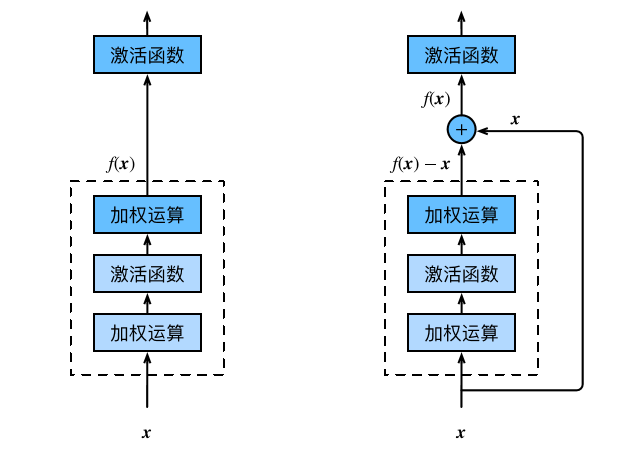

In [6]:
class Residual(nn.Module):  # 本类已保存在d2lzh_pytorch包中方便以后使用
    #可以设定输出通道数、是否使用额外的1x1卷积层来修改通道数以及卷积层的步幅。
    def __init__(self, in_channels, out_channels, use_1x1conv=False, stride=1):
        super(Residual, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        return F.relu(Y + X)

In [7]:
blk = Residual(3, 3)
X = torch.rand((4, 3, 6, 6))
blk(X).shape # torch.Size([4, 3, 6, 6])

torch.Size([4, 3, 6, 6])

In [8]:
blk = Residual(3, 6, use_1x1conv=True, stride=2)
blk(X).shape # torch.Size([4, 6, 3, 3])

torch.Size([4, 6, 3, 3])

### ResNet模型
卷积(64,7x7,3)  
批量一体化  
最大池化(3x3,2)  

残差块x4 (通过步幅为2的残差块在每个模块之间减小高和宽)

全局平均池化

全连接

In [9]:
net = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
        nn.BatchNorm2d(64), 
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [10]:
def resnet_block(in_channels, out_channels, num_residuals, first_block=False):
    if first_block:
        assert in_channels == out_channels # 第一个模块的通道数同输入通道数一致
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(in_channels, out_channels, use_1x1conv=True, stride=2))
        else:
            blk.append(Residual(out_channels, out_channels))
    return nn.Sequential(*blk)

net.add_module("resnet_block1", resnet_block(64, 64, 2, first_block=True))
net.add_module("resnet_block2", resnet_block(64, 128, 2))
net.add_module("resnet_block3", resnet_block(128, 256, 2))
net.add_module("resnet_block4", resnet_block(256, 512, 2))

In [11]:
net.add_module("global_avg_pool", d2l.GlobalAvgPool2d()) # GlobalAvgPool2d的输出: (Batch, 512, 1, 1)
net.add_module("fc", nn.Sequential(d2l.FlattenLayer(), nn.Linear(512, 10))) 

In [12]:
X = torch.rand((1, 1, 224, 224))
for name, layer in net.named_children():
    X = layer(X)
    print(name, ' output shape:\t', X.shape)

0  output shape:	 torch.Size([1, 64, 112, 112])
1  output shape:	 torch.Size([1, 64, 112, 112])
2  output shape:	 torch.Size([1, 64, 112, 112])
3  output shape:	 torch.Size([1, 64, 56, 56])
resnet_block1  output shape:	 torch.Size([1, 64, 56, 56])
resnet_block2  output shape:	 torch.Size([1, 128, 28, 28])
resnet_block3  output shape:	 torch.Size([1, 256, 14, 14])
resnet_block4  output shape:	 torch.Size([1, 512, 7, 7])
global_avg_pool  output shape:	 torch.Size([1, 512, 1, 1])
fc  output shape:	 torch.Size([1, 10])


In [13]:
lr, num_epochs = 0.001, 5
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
d2l.train_ch5(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs)

# 稠密连接网络（DenseNet）

![Image Name](https://cdn.kesci.com/upload/image/q5l8mi78yz.png?imageView2/0/w/600/h/600)

###主要构建模块：  
稠密块（dense block）： 定义了输入和输出是如何连结的。  
过渡层（transition layer）：用来控制通道数，使之不过大。
### 稠密块
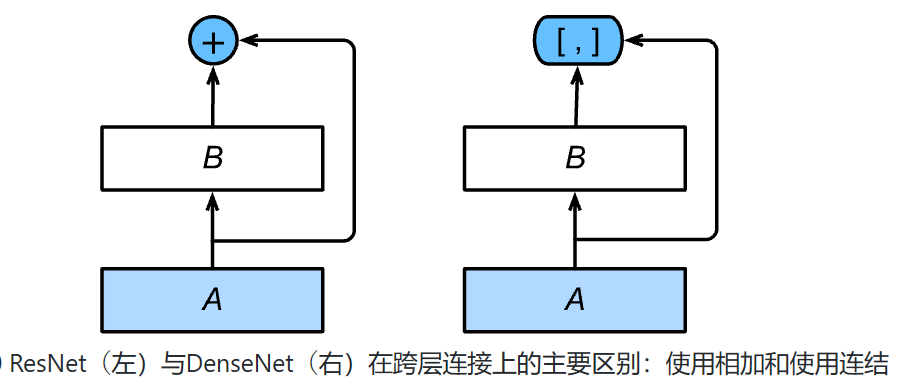

In [13]:
def conv_block(in_channels, out_channels):
    blk = nn.Sequential(nn.BatchNorm2d(in_channels), 
                        nn.ReLU(),
                        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
    return blk

class DenseBlock(nn.Module):
    def __init__(self, num_convs, in_channels, out_channels):
        super(DenseBlock, self).__init__()
        net = []
        for i in range(num_convs):
            in_c = in_channels + i * out_channels
            net.append(conv_block(in_c, out_channels))
        self.net = nn.ModuleList(net)
        self.out_channels = in_channels + num_convs * out_channels # 计算输出通道数

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            X = torch.cat((X, Y), dim=1)  # 在通道维上将输入和输出连结
        return X

In [14]:
blk = DenseBlock(2, 3, 10)
X = torch.rand(4, 3, 8, 8)
Y = blk(X)
Y.shape # torch.Size([4, 23, 8, 8])

torch.Size([4, 23, 8, 8])

### 过渡层
$1\times1$卷积层：来减小通道数  
步幅为2的平均池化层：减半高和宽

In [15]:
def transition_block(in_channels, out_channels):
    blk = nn.Sequential(
            nn.BatchNorm2d(in_channels), 
            nn.ReLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.AvgPool2d(kernel_size=2, stride=2))
    return blk

blk = transition_block(23, 10)
blk(Y).shape # torch.Size([4, 10, 4, 4])

torch.Size([4, 10, 4, 4])

### DenseNet模型

In [16]:
net = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
        nn.BatchNorm2d(64), 
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [17]:
num_channels, growth_rate = 64, 32  # num_channels为当前的通道数
num_convs_in_dense_blocks = [4, 4, 4, 4]

for i, num_convs in enumerate(num_convs_in_dense_blocks):
    DB = DenseBlock(num_convs, num_channels, growth_rate)
    net.add_module("DenseBlosk_%d" % i, DB)
    # 上一个稠密块的输出通道数
    num_channels = DB.out_channels
    # 在稠密块之间加入通道数减半的过渡层
    if i != len(num_convs_in_dense_blocks) - 1:
        net.add_module("transition_block_%d" % i, transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2

In [18]:
net.add_module("BN", nn.BatchNorm2d(num_channels))
net.add_module("relu", nn.ReLU())
net.add_module("global_avg_pool", d2l.GlobalAvgPool2d()) # GlobalAvgPool2d的输出: (Batch, num_channels, 1, 1)
net.add_module("fc", nn.Sequential(d2l.FlattenLayer(), nn.Linear(num_channels, 10))) 

X = torch.rand((1, 1, 96, 96))
for name, layer in net.named_children():
    X = layer(X)
    print(name, ' output shape:\t', X.shape)

0  output shape:	 torch.Size([1, 64, 48, 48])
1  output shape:	 torch.Size([1, 64, 48, 48])
2  output shape:	 torch.Size([1, 64, 48, 48])
3  output shape:	 torch.Size([1, 64, 24, 24])
DenseBlosk_0  output shape:	 torch.Size([1, 192, 24, 24])
transition_block_0  output shape:	 torch.Size([1, 96, 12, 12])
DenseBlosk_1  output shape:	 torch.Size([1, 224, 12, 12])
transition_block_1  output shape:	 torch.Size([1, 112, 6, 6])
DenseBlosk_2  output shape:	 torch.Size([1, 240, 6, 6])
transition_block_2  output shape:	 torch.Size([1, 120, 3, 3])
DenseBlosk_3  output shape:	 torch.Size([1, 248, 3, 3])
BN  output shape:	 torch.Size([1, 248, 3, 3])
relu  output shape:	 torch.Size([1, 248, 3, 3])
global_avg_pool  output shape:	 torch.Size([1, 248, 1, 1])
fc  output shape:	 torch.Size([1, 10])


In [20]:
#batch_size = 256
batch_size=16
# 如出现“out of memory”的报错信息，可减小batch_size或resize
train_iter, test_iter =load_data_fashion_mnist(batch_size, resize=96)
lr, num_epochs = 0.001, 5
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
d2l.train_ch5(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs)